In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error


In [6]:
# Load the data
historical_quotes = pd.read_csv('HistoricalQuotes.csv')
portfolio_data = pd.read_csv('portfolio_data.csv')
tesla_data = pd.read_csv("E:\ML PROJECTS\Stock analysis\Tesla.csv - Tesla.csv.csv")

# Display the first few rows of each dataset to understand their structure
print("Historical Quotes:")
print(historical_quotes.head())

print("\nPortfolio Data:")
print(portfolio_data.head())

print("\nTesla Data:")
print(tesla_data.head())


Historical Quotes:
         Date  Close/Last     Volume      Open      High       Low
0  02/28/2020     $273.36  106721200   $257.26   $278.41   $256.37
1  02/27/2020     $273.52   80151380    $281.1      $286   $272.96
2  02/26/2020     $292.65   49678430   $286.53   $297.88    $286.5
3  02/25/2020     $288.08   57668360   $300.95   $302.53   $286.13
4  02/24/2020     $298.18   55548830   $297.26   $304.18   $289.23

Portfolio Data:
       Date        AMZN        DPZ         BTC       NFLX
0  5/1/2013  248.229996  51.190983  106.250000  30.415714
1  5/2/2013  252.550003  51.987320   98.099998  30.641428
2  5/3/2013  258.049988  52.446388  112.900002  30.492857
3  5/6/2013  255.720001  53.205257  109.599998  30.098572
4  5/7/2013  257.730011  54.151505  113.199997  29.464285

Tesla Data:
        Date       Open   High        Low      Close    Volume  Adj Close
0  6/29/2010  19.000000  25.00  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.42  23.299999  23.830000 

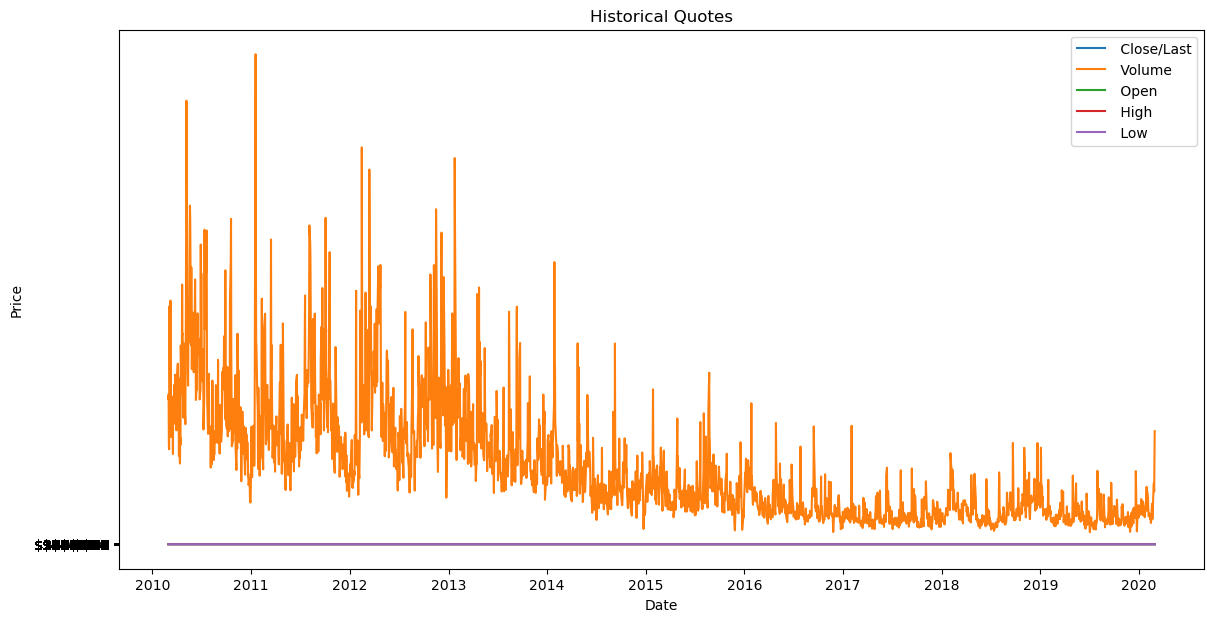

In [7]:
# Convert Date columns to datetime
historical_quotes['Date'] = pd.to_datetime(historical_quotes['Date'])
historical_quotes.set_index('Date', inplace=True)

# Plot the closing prices of different stocks
plt.figure(figsize=(14,7))
for column in historical_quotes.columns:
    plt.plot(historical_quotes.index, historical_quotes[column], label=column)
plt.title('Historical Quotes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


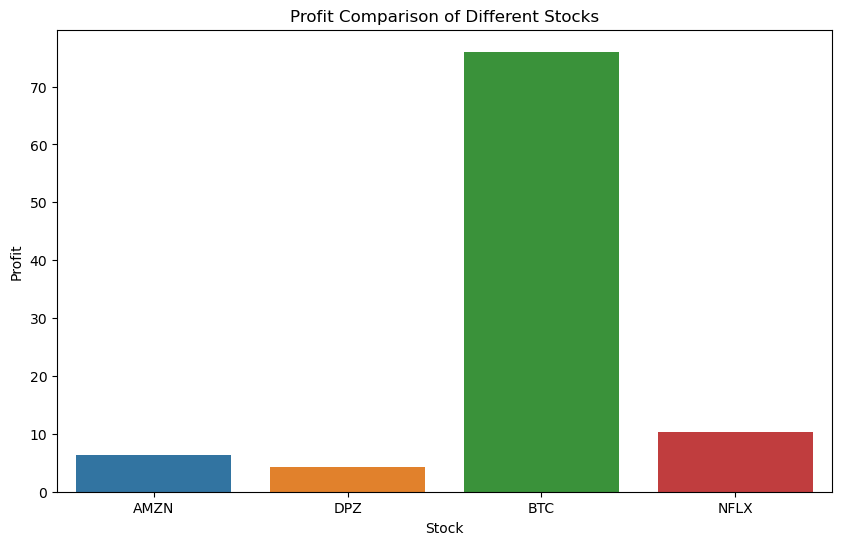

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Transform the data to match the expected format
transformed_data = pd.DataFrame({
    'Stock': portfolio_data.columns[1:],
    'Open': portfolio_data.iloc[0, 1:].values,
    'Close': portfolio_data.iloc[-1, 1:].values
})

# Calculate profits
profits = (transformed_data['Close'] - transformed_data['Open']) / transformed_data['Open']

# Calculate risks
risks = portfolio_data.iloc[:, 1:].pct_change().std()

# Create a DataFrame for visualization
profit_risk_df = pd.DataFrame({
    'Stock': transformed_data['Stock'],
    'Profit': profits,
    'Risk': risks.values
})

# Bar Graph for Profits
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Profit', data=profit_risk_df)
plt.title('Profit Comparison of Different Stocks')
plt.xlabel('Stock')
plt.ylabel('Profit')
plt.show()


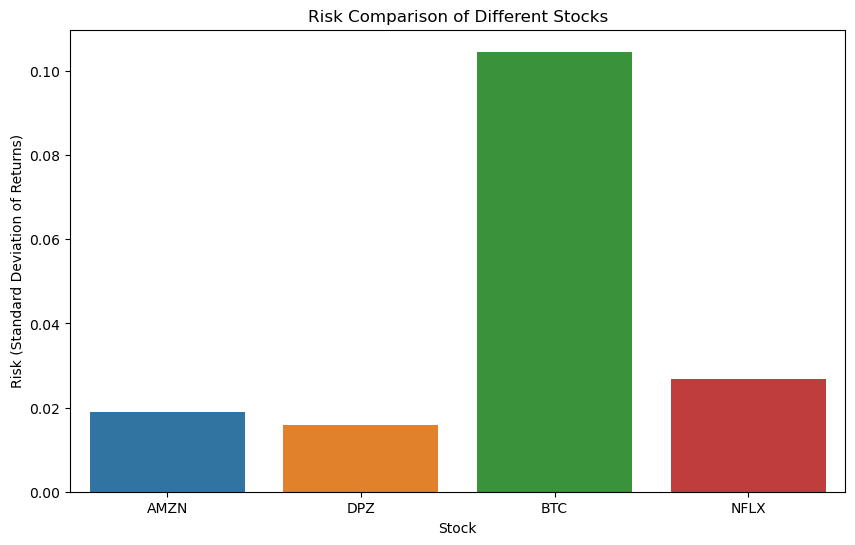

In [19]:
# Bar Graph for Risks
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Risk', data=profit_risk_df)
plt.title('Risk Comparison of Different Stocks')
plt.xlabel('Stock')
plt.ylabel('Risk (Standard Deviation of Returns)')
plt.show()

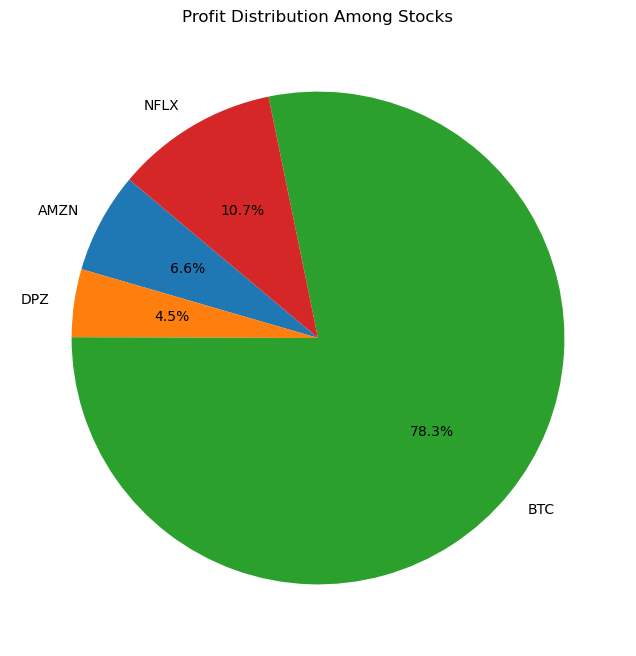

In [20]:

# Pie Chart for Profits
plt.figure(figsize=(8, 8))
plt.pie(profit_risk_df['Profit'], labels=profit_risk_df['Stock'], autopct='%1.1f%%', startangle=140)
plt.title('Profit Distribution Among Stocks')
plt.show()

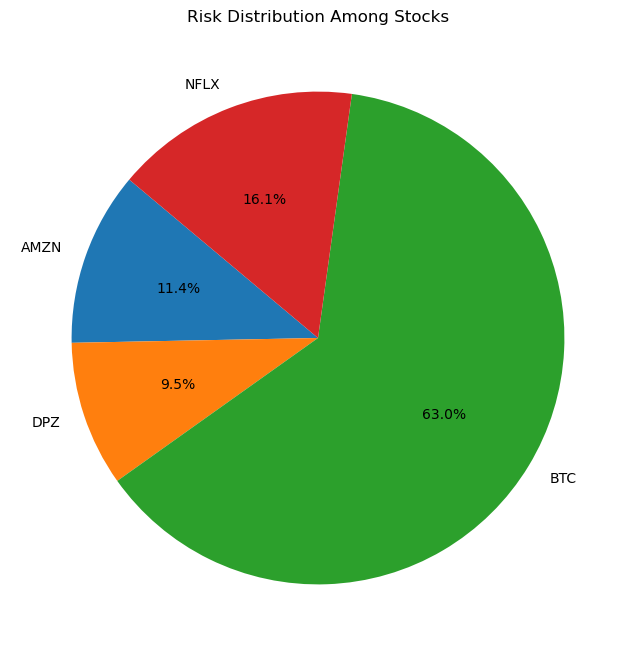

In [21]:
# Pie Chart for Risks
plt.figure(figsize=(8, 8))
plt.pie(profit_risk_df['Risk'], labels=profit_risk_df['Stock'], autopct='%1.1f%%', startangle=140)
plt.title('Risk Distribution Among Stocks')
plt.show()

In [11]:
# Convert Date column to datetime
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Use the 'Close' column for prediction
close_prices = tesla_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


In [12]:
# Define a function to create a dataset with lookback
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), 0]
        X.append(a)
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

# Define lookback period
lookback = 60

# Create the dataset
X, y = create_dataset(scaled_data, lookback)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data to be 3D [samples, time steps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=1, validation_data=(X_test, y_test))





1304/1304 [==============================] - 57s 40ms/step - loss: 0.0031 - val_loss: 0.0053


In [14]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train_actual[0], train_predict)
test_mape = mean_absolute_percentage_error(y_test_actual[0], test_predict)
print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')

# Calculate accuracy
train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape
print(f'Train Accuracy: {train_accuracy}%')
print(f'Test Accuracy: {test_accuracy}%')


11/11 [==============================] - 0s 21ms/step
Train RMSE: 13.88090697854715
Test RMSE: 19.59268054312401
Train MAPE: 169.18405526273364
Test MAPE: 13.065290380380432
Train Accuracy: -69.18405526273364%
Test Accuracy: 86.93470961961957%


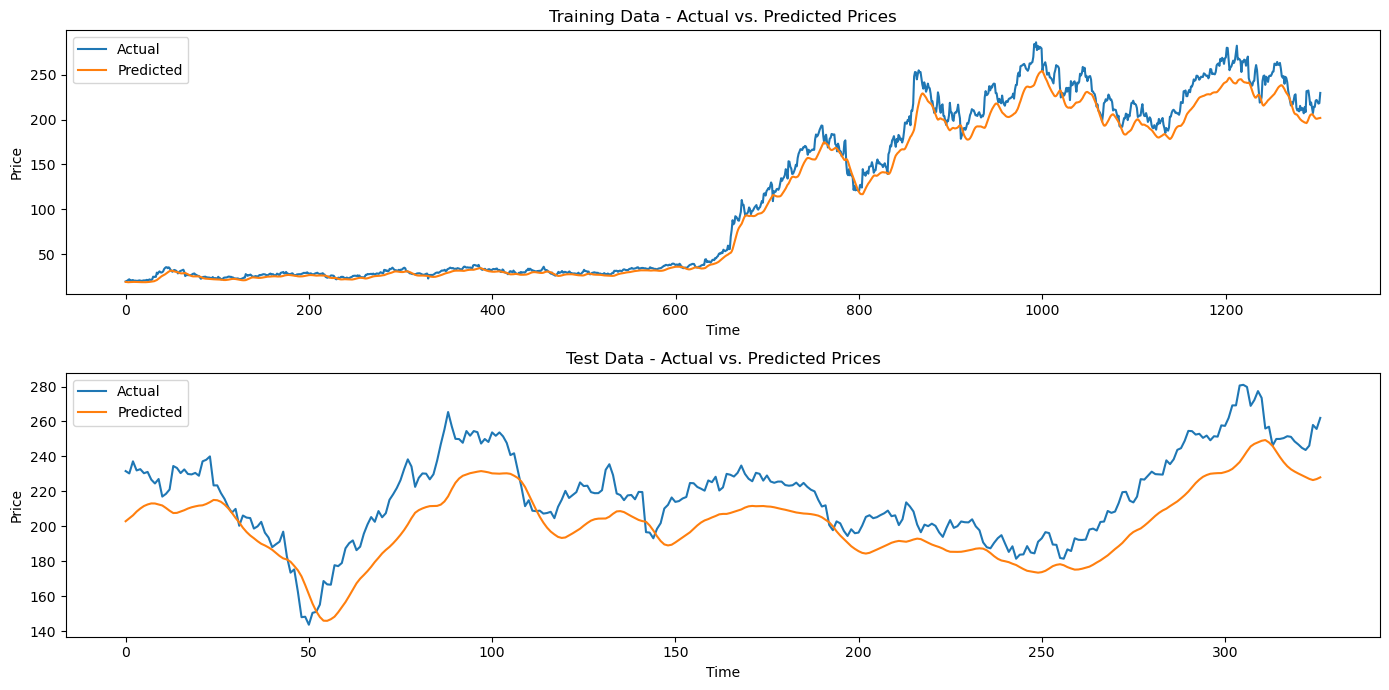

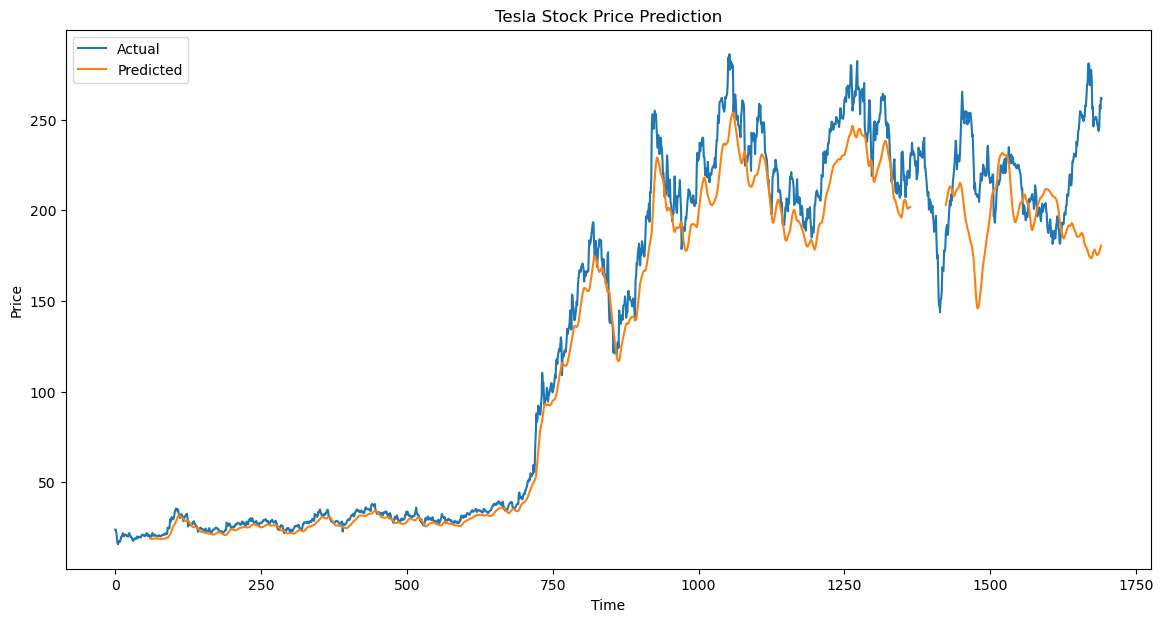

In [17]:
# Plot actual vs. predicted prices for training and test sets
plt.figure(figsize=(14, 7))

# Plot training data
plt.subplot(2, 1, 1)
plt.plot(y_train_actual[0], label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data - Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Plot test data
plt.subplot(2, 1, 2)
plt.plot(y_test_actual[0], label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Test Data - Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize the entire time series with predictions
# Create an array to hold the entire dataset including predictions
full_data = np.empty_like(scaled_data)
full_data[:, :] = np.nan
full_data[lookback:len(train_predict) + lookback, 0] = train_predict[:, 0]

# Place the test predictions after the training predictions
full_data[len(train_predict) + (lookback * 2):len(scaled_data) - 1, 0] = test_predict[:len(scaled_data) - len(train_predict) - (lookback * 2) - 1, 0]

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual')
plt.plot(full_data, label='Predicted')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
